In [64]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
from vosk import Model
from Signal_Analysis.features.signal import get_HNR
from scipy import signal
from audiostretchy.stretch import stretch_audio
import pandas as pd

# tools work in progress
import tools

reload(tools)

plt.style.use("dark_background")
mpl.rcParams["lines.linewidth"] = 0.5
plt.close("all")

## audio, labels, speech recognition

0 på ------------------ from 0.6600 to 0.8400 sec, confidence: 100.00%
1 många --------------- from 0.8400 to 1.1400 sec, confidence: 100.00%
2 skolor -------------- from 1.1400 to 1.7700 sec, confidence: 100.00%
3 saknas -------------- from 1.8000 to 2.5200 sec, confidence: 100.00%
4 såväl --------------- from 2.5200 to 2.8800 sec, confidence: 100.00%
5 digitala ------------ from 2.8800 to 3.6000 sec, confidence: 100.00%
6 som ----------------- from 3.8100 to 3.9900 sec, confidence: 100.00%
7 analoga ------------- from 3.9900 to 4.5900 sec, confidence: 100.00%
8 resurser ------------ from 4.5900 to 5.2500 sec, confidence: 100.00%
på många skolor saknas såväl digitala som analoga resurser


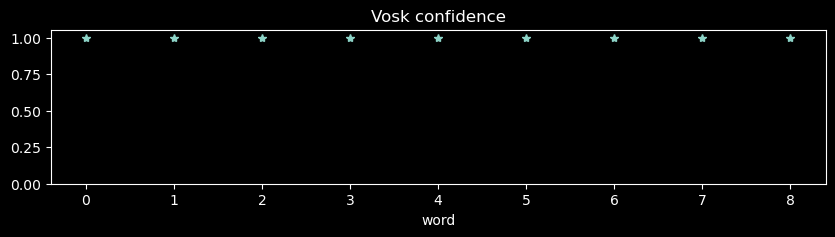

In [65]:
# labels_path = (
#    "example_speech_Andreas/180923214834-Y20UOTIE-text-000_vowels_timestamp_praat"
# )
labels_path = "wav_examples/digitala_vowels_manual_timestamps.csv"

labels_df = pd.read_csv(labels_path)
# audio_path = "audio_preproc/180923214834-Y20UOTIE-text-000_pp.wav"
audio_path = "wav_examples/digitala_resurser_sv.wav"
# audio_path = "audio_preproc/digitala_trash2_pp.wav"

Fs, audio = wavfile.read(audio_path)
model_path = "models/vosk-model-small-sv-rhasspy-0.15/"

if "model" not in locals():
    model = Model(model_path)

words = tools.rec_vosk(audio_path, model, print_summary=True)

text = " ".join([w["word"] for w in words])

# get all vowels
for w in words:
    w["vowels"] = tools.checkVowels(w["word"], tools.VOWELS_SV)


print(text)
plt.figure(figsize=(10, 2))
plt.plot([w["conf"] for w in words], "*")
plt.title("Vosk confidence")
plt.xlabel("word")
plt.ylim(bottom=0)
plt.show()

trash på
keep många
trash skolor
keep saknas
keep såväl
keep digitala
trash som
keep analoga
keep resurser


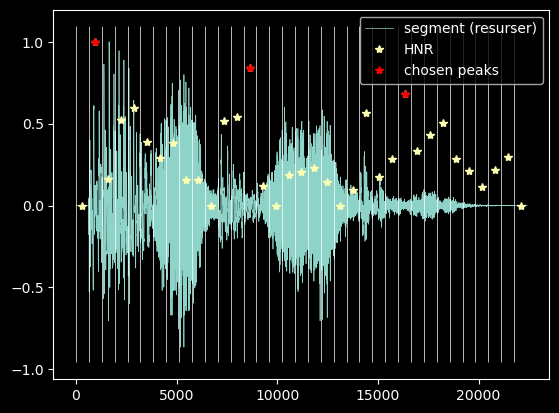

found vowels:
     e 2 100.0%
     y 0 0.0%
     u 1 100.0%
     i 2 100.0%
     o 1 25.0%
     å 2 66.667%
     a 8 100.0%
     ö 0 0.0%
     ä 1 100.0%
total: vowels in text 21
2
0
1
2
4
3
8
0
1


In [66]:
reload(tools)
add_context = False
fl = int(0.02 * Fs)
grouped_frames = tools.julgran(
    words, audio, Fs, fl, add_context, long_frame=False, plot_word="resurser"
)

vowels_in_text = {v: 0 for v in tools.VOWELS_SV}
for c in tools.checkVowels(text, tools.VOWELS_SV):
    vowels_in_text[c] += 1


print("found vowels:")
for v in grouped_frames.keys():
    print(
        "    ",
        v,
        len(grouped_frames[v]["frame"]),
        str(round(100 * len(grouped_frames[v]["frame"]) / max(vowels_in_text[v], 1), 3))
        + "%",
    )

print("total: vowels in text", sum([vowels_in_text[v] for v in vowels_in_text.keys()]))
for v in vowels_in_text.keys():
    print(vowels_in_text[v])

In [67]:
reload(tools)
starts_all, stops_all, vowels_all = tools.groupedframes_to_lists(grouped_frames)
tools.score_vs_labels(starts_all, stops_all, labels_df, vowels=vowels_all, snäll=True)

total found vowels: 17
unique start points: 17
unique stop points: 17
We got i
Correct vowel a
included: 10
Assuming Tobias.exe perfect and all vowels correctly classified:
precision: 0.5882352941176471
recall: 0.47619047619047616


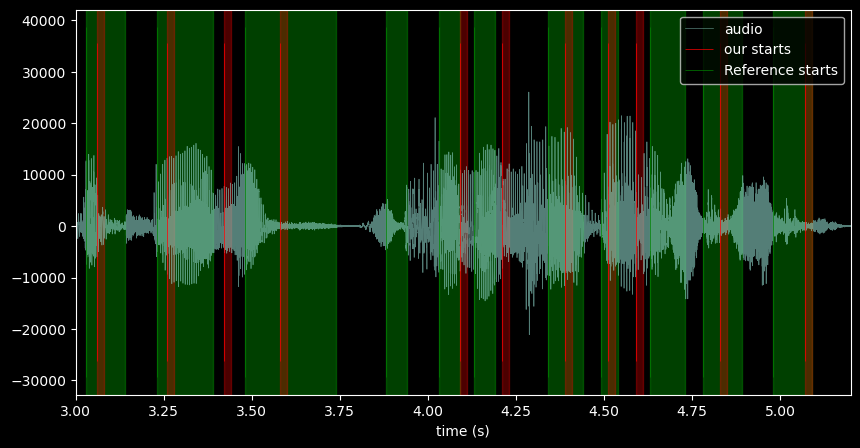

In [71]:
plt.figure(figsize=(10, 5))

tt = np.arange(len(audio)) / Fs
plt.plot(tt, audio, alpha=0.6, label="audio")
plt.vlines(starts_all, *plt.ylim(), colors="r", label="our starts")
plt.vlines(labels_df.tmin, *plt.ylim(), colors="g", label="Reference starts")
for tmin, tmax in zip(labels_df.tmin, labels_df.tmax):
    plt.axvspan(tmin, tmax, alpha=0.5, color="g")

for start, stop in zip(starts_all, stops_all):
    plt.axvspan(start, stop, alpha=0.3, color="r")


plt.xlabel("time (s)")

tr = (0, len(audio) / Fs)
tr = (3, 5.2)

plt.xlim(*tr)
plt.legend()
plt.show()

In [69]:
wavfile.write(
    "output/test.wav", Fs, tools.wavScaler(audio[int(tr[0] * Fs) : int(tr[1] * Fs)])
)

## outlier filter

In [70]:
# reload(tools)
# frames_inliers = tools.outlier_filter(grouped_frames, Fs)
# starts_all_seconds_in, stops_all_seconds_in = tools.get_start_stop_seconds(
#     frames_inliers, fl, Fs
# )

# tools.score_vs_labels(starts_all_seconds_in, stops_all_seconds_in, labels_df)